In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import module as mod
#import tslearn as ts

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [8]:
house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


On peut essayer de voir quelle est la fenêtre de temps optimale pour nos features générées

In [3]:
all_windows = ['2min', '5min', '10min', '30min', '1h', '2h', '3h', '5h', '12h']

features_cols = []
for i, rolling_window in enumerate(all_windows):
    house1_power_blk2, cols = mod.generate_features(house1_power_blk2, window=rolling_window)
    features_cols += cols

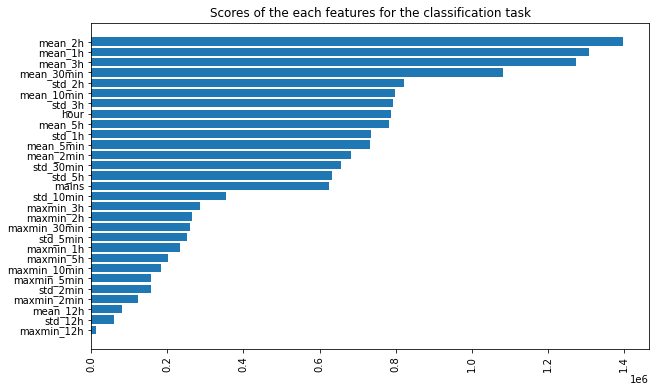

In [4]:
# ideally this would be done after a split test / train
fs = SelectKBest()
all_features = ['mains', 'hour'] + features_cols
fs.fit_transform(house1_power_blk2.loc[:, all_features].values, house1_power_blk2.loc[:, 'activity'].values)

sorted_scores_idx = np.argsort(fs.scores_)

fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);
#plt.bar(x=range(len(fs.scores_)), height=fs.scores_);
plt.xticks(rotation=90)
plt.title('Scores of the each features for the classification task');

2 heures semble optimal, mais 1 heure semble aussi bien fonctionner et cette durée a l'air plus adaptée pour la maison 2. Nous allons donc choisir une fenêtre de 1 heure. Nous allons également choisir une deuxième fenêtre de 5 minutes pour avoir une fenêtre log terme et une fenêtre court terme.

In [5]:
best_windows = ['1h', '5min']
features_col = ['mains', 'hour'] + [func+window for window in best_windows for func in ['std_', 'mean_', 'maxmin_']]

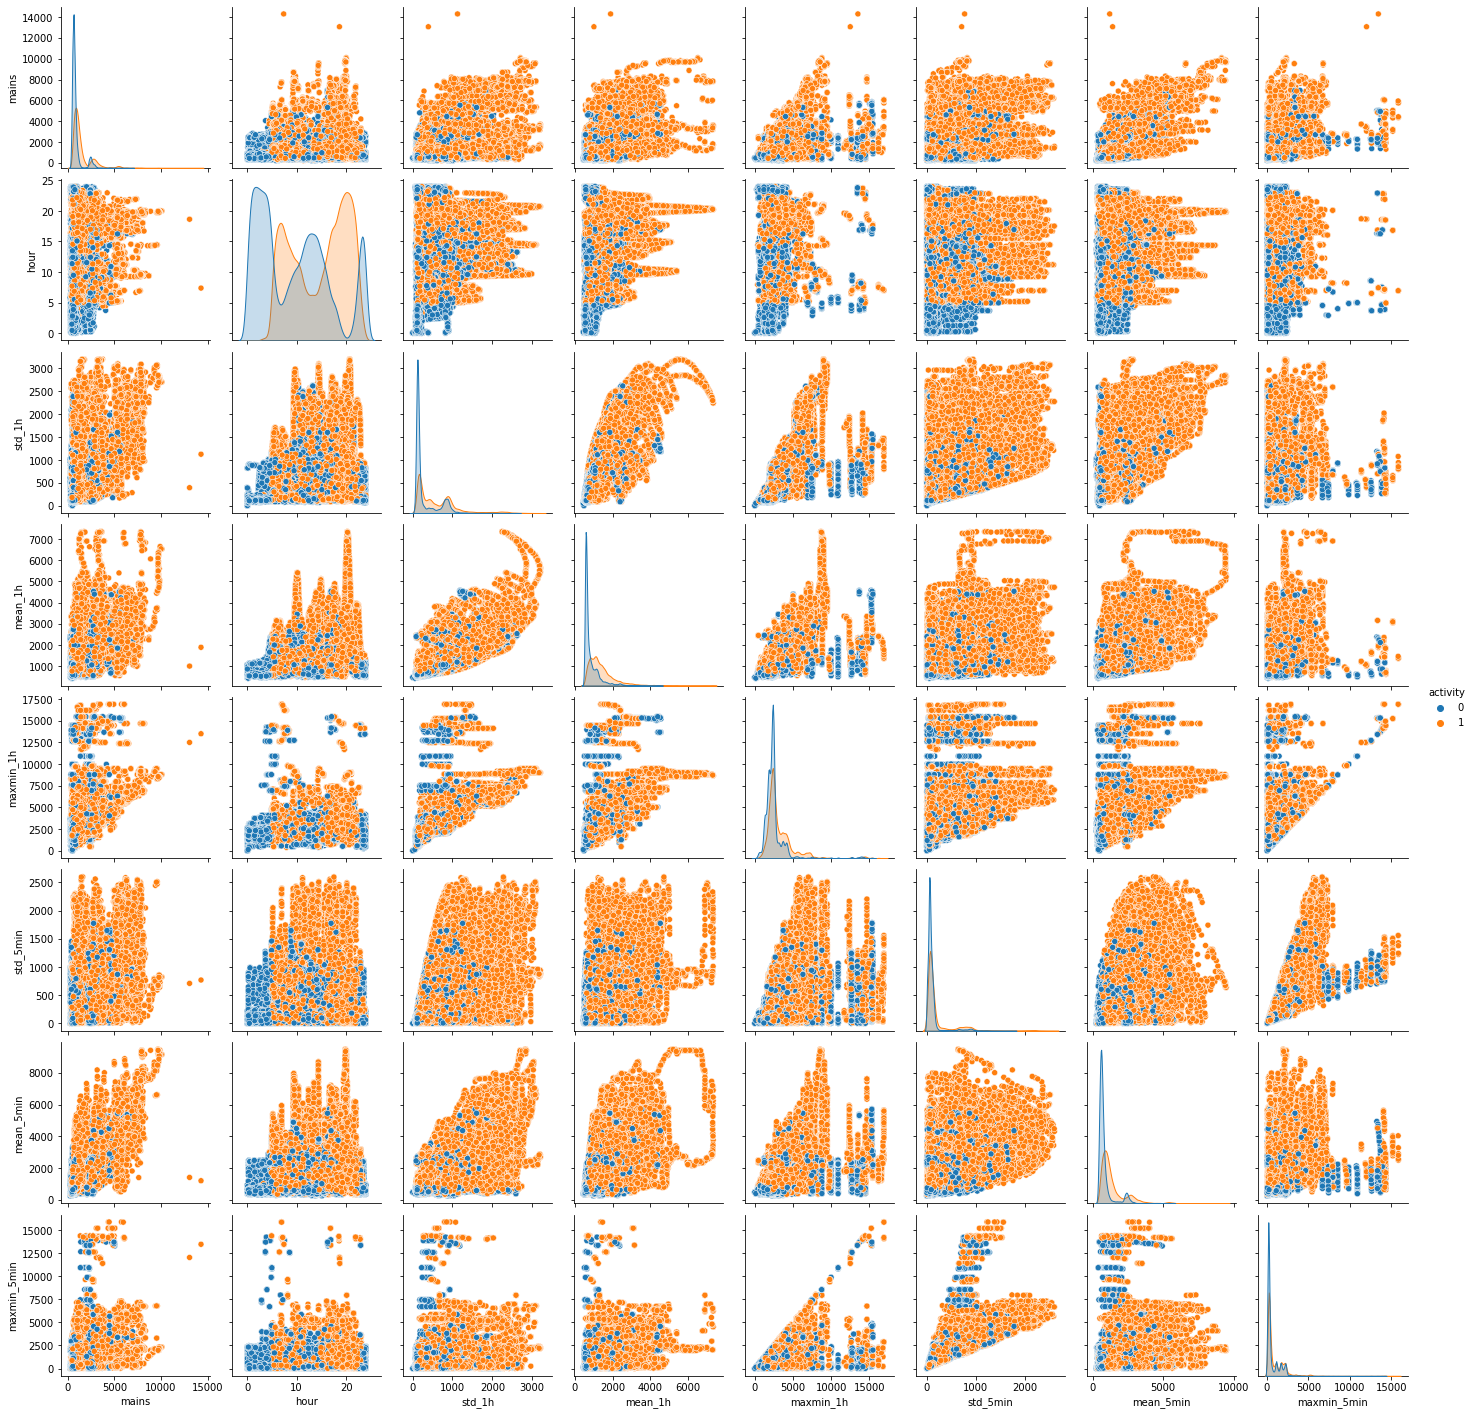

In [6]:
sns.pairplot(house1_power_blk2[features_col + ['activity']].sample(frac=0.1), hue='activity');

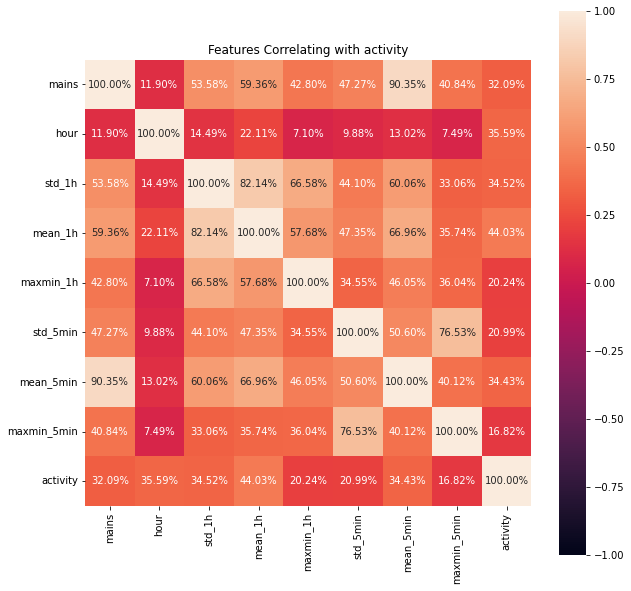

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(house1_power_blk2[features_col + ['activity']].corr(), vmin=-1, vmax=1, annot=True, fmt='.2%', square=True)
ax.set_title('Features Correlating with activity');

# 2. Train / test split

In [9]:
best_windows = ['1h', '5min']

features_col = ['mains', 'hour']
for window in best_windows:
    house1_power_blk2, cols = mod.generate_features(house1_power_blk2, window=window)
    features_col += cols

X_train, X_test, y_train, y_test = mod.split_train_test_scale_df(house1_power_blk2, features_col)

# 3. Algorithmes généraux

Score f_beta : 75.858%
Score accuracy : 75.858%


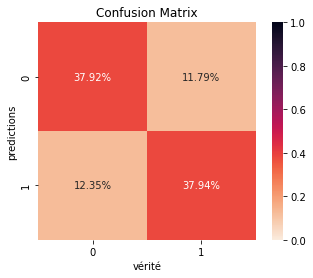

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

tested n_neighbors=1 ...
tested n_neighbors=5 ...
tested n_neighbors=10 ...
tested n_neighbors=30 ...
tested n_neighbors=60 ...
tested n_neighbors=90 ...


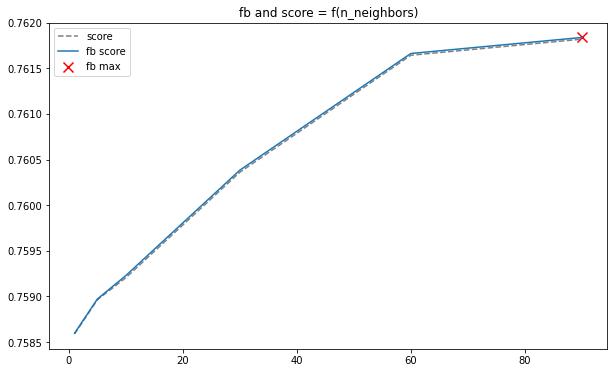

Meilleur fb score=0.76 obtenu pour n_neighbors=90.00
Score f_beta : 76.184%
Score accuracy : 76.182%


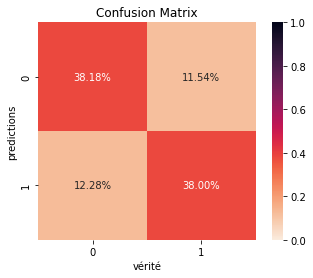

In [12]:
from sklearn.neighbors import KNeighborsClassifier

k_range = [1, 5, 10, 30, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);

tested n_estimators=1 ...
tested n_estimators=30 ...
tested n_estimators=60 ...
tested n_estimators=90 ...


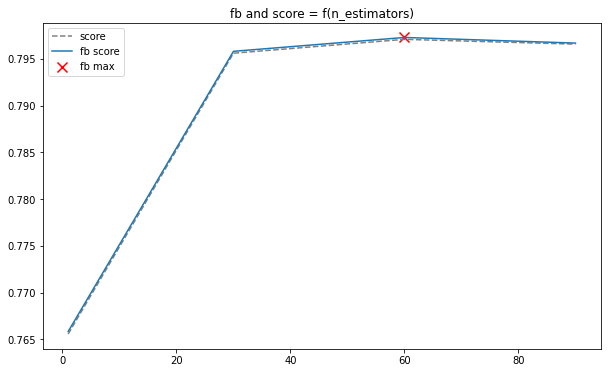

Meilleur fb score=0.80 obtenu pour n_estimators=60.00
Score f_beta : 79.593%
Score accuracy : 79.593%


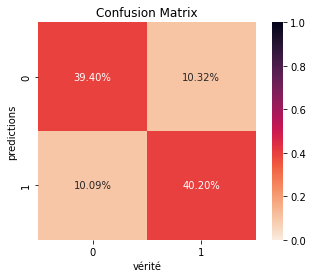

In [13]:
from sklearn.ensemble import RandomForestClassifier

n_range = [1, 30, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 10});

tested max_depth=20 ...
tested max_depth=40 ...
tested max_depth=60 ...
tested max_depth=80 ...


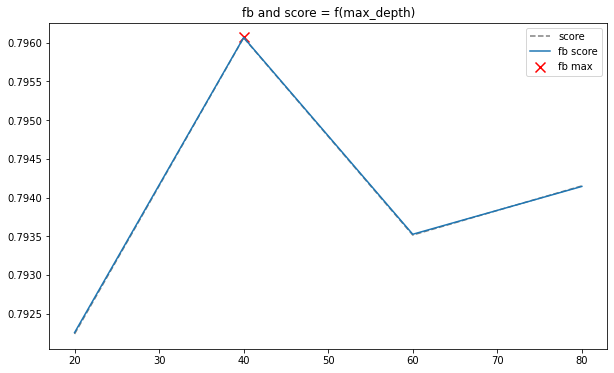

Meilleur fb score=0.80 obtenu pour max_depth=40.00
Score f_beta : 79.740%
Score accuracy : 79.741%


('max_depth', 40, 0.7960635288065844, 0.7960677370252542)

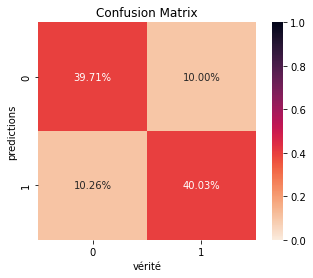

In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier

n_range = [20, 40, 60, 80]
mod.plot_scores_param(X_train, X_test, y_train, y_test, HistGradientBoostingClassifier, 'max_depth', n_range, other_params={'max_iter': 300})

# 3. Algorithmes sur Time Series

In [34]:
from tslearn.utils import to_time_series
from tslearn.preprocessing import TimeSeriesScalerMinMax

X_train, X_test = to_time_series(house1_power_blk2.loc[train_indexes, 'mains']), to_time_series(house1_power_blk2.loc[test_indexes, 'mains'])
y_train, y_test = house1_power_blk2.loc[train_indexes, 'activity'].values, house1_power_blk2.loc[test_indexes, 'activity'].values

scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsTimeSeriesClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

scores = []
fb_scores = []
k_range = range(1, 4)
for k in range(1, 4):
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    fb_scores.append(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
    scores.append(accuracy_score(y_test, y_pred))

best_param = np.argmax(fb_scores)

plt.figure(figsize=(10, 6));
plt.plot(k_range, scores, label='score', color='grey', linestyle='dashed');
plt.plot(k_range, fb_scores, label='fb score');
plt.scatter(k_range[best_param], fb_scores[best_param], label='fb min', marker='x', s=100, color='red')
plt.legend();
plt.title('fb and score = f(k)');
plt.show();

print('Meilleur fb score={:.2f} obtenu pour b={:.2f}'.format(fb_scores[best_param], k_range[best_param]))

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', cmap='turbo');
plt.title('Resultats avec b={:.2f}'.format(k_range[best_param]));
plt.show();


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from dtw import dtw

def dtw_dist(x,y):
    d = dtw(x, y)
    return d.distance

knn = KNeighborsClassifier(n_neighbors=3, metric=dtw_dist)
knn.fit(X_train.ravel().reshape((-1,1)), y_train.round().ravel())
knn.score(X_test.ravel().reshape((-1,1)), y_test.round().ravel())